
<a href="https://colab.research.google.com/github/takzen/ai-engineering-handbook/blob/main/notebooks/002_Advanced_Feature_Selection.ipynb" target="_parent">
    <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>



<a href="https://colab.research.google.com/github/takzen/ai-engineering-handbook/blob/main/02_Advanced_Feature_Selection.ipynb" target="_parent">
    <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>


# 🚀 Advanced Feature Selection: Dlaczego korelacja kłamie? (SHAP & Mutual Info)

W poprzednim notatniku o korelacjach nauczyliśmy się używać Pearsona. Ma on jednak gigantyczną wadę: **Widzi tylko linie proste.**

Jeśli Twoja dana zależy od innej w sposób nieliniowy (np. jak parabola `U` – "za mało źle, za dużo źle, średnio najlepiej"), to **Korelacja Pearsona pokaże 0**. Powie Ci: "Te dane nie mają związku", co jest kłamstwem!

Dziś poznamy narzędzia, których używa się w prawdziwych firmach AI, żeby nie dać się oszukać:
1.  **Mutual Information (Informacja Wzajemna):** Wykrywa KAŻDĄ zależność (nawet fale, kółka, parabole).
2.  **Permutation Importance:** Najuczciwszy test ważności (miesza dane i sprawdza, czy model zgłupiał).
3.  **SHAP:** Złoty standard wyjaśnialności AI (dlaczego model podjął taką decyzję?).

In [6]:
# Instalujemy bibliotekę SHAP (często nie ma jej domyślnie w Colab)
# !pip install shap --quiet  <-- Odkomentuj jeśli działasz w Colab

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Narzędzia
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import mutual_info_regression
from sklearn.inspection import permutation_importance
import shap

sns.set_theme(style="whitegrid")
print("Biblioteki gotowe! Jedziemy z nowoczesnym AI.")

Biblioteki gotowe! Jedziemy z nowoczesnym AI.


## Krok 1: Pułapka na Pearsona (Generujemy Dane)

Stworzymy dane, które oszukają klasyczną statystykę. Wyobraź sobie **wydajność silnika**:
1.  **Cecha Liniowa:** Obroty silnika (im szybciej, tym głośniej). Prosta sprawa.
2.  **Cecha Paraboliczna (Pułapka):** Temperatura oleju.
    *   Zimny olej = Źle.
    *   Gorący olej = Źle.
    *   Letni olej = Idealnie.
    *   To tworzy wykres w kształcie litery `U` (lub odwróconego U).
3.  **Szum:** Kolor karoserii (losowe liczby, bez wpływu na silnik).

Korelacja Pearsona dla Paraboli: -0.0166
---
Widzisz? Wynik bliski ZERA! Statystyka twierdzi, że Parabola nie ma znaczenia.
A teraz spójrz na wykres:


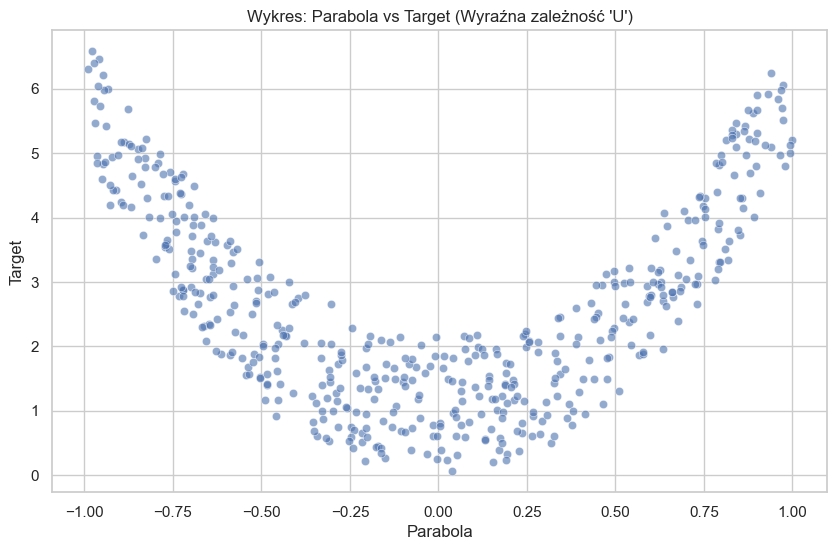

In [7]:
np.random.seed(42)
n = 500

# 1. Cecha Liniowa (Im więcej X, tym więcej Y)
x_lin = np.random.rand(n)

# 2. Cecha Paraboliczna (Wartości od -1 do 1)
# To będzie nasza pułapka. Zależność to X do kwadratu.
x_parabola = np.random.uniform(-1, 1, n)

# 3. Szum (Losowe śmieci)
x_szum = np.random.rand(n)

# TWORZYMY TARGET (Y - np. Wydajność)
# Wzór: 2*Liniowa + 5*(Parabola^2) + Szum
y = 2 * x_lin + 5 * (x_parabola ** 2) + np.random.normal(0, 0.1, n)

df = pd.DataFrame({
    'Liniowa': x_lin,
    'Parabola': x_parabola, # Tu Pearson zgłupieje
    'Szum': x_szum,
    'Target': y
})

# SPRAWDŹMY KORELACJĘ PEARSONA
pearson = df.corr()['Target']['Parabola']
print(f"Korelacja Pearsona dla Paraboli: {pearson:.4f}")
print("---")
print("Widzisz? Wynik bliski ZERA! Statystyka twierdzi, że Parabola nie ma znaczenia.")
print("A teraz spójrz na wykres:")

sns.scatterplot(data=df, x='Parabola', y='Target', alpha=0.6)
plt.title("Wykres: Parabola vs Target (Wyraźna zależność 'U')")
plt.show()

## Metoda 1: Mutual Information (Wykrywacz Wszelkiego Sygnału)

Skoro Pearson jest ślepy na łuki, użyjmy **Mutual Information**.
Ta metoda nie pyta *"Czy to jest prosta linia?"*.
Ona pyta: *"O ile mniejsza jest moja niewiedza na temat Y, jeśli znam X?"*.

Działa na każdy kształt. Wynik 0 = brak zależności. Im więcej = tym lepiej.

--- WYNIKI MUTUAL INFORMATION ---
Parabola    0.891963
Liniowa     0.269643
Szum        0.000000
dtype: float64


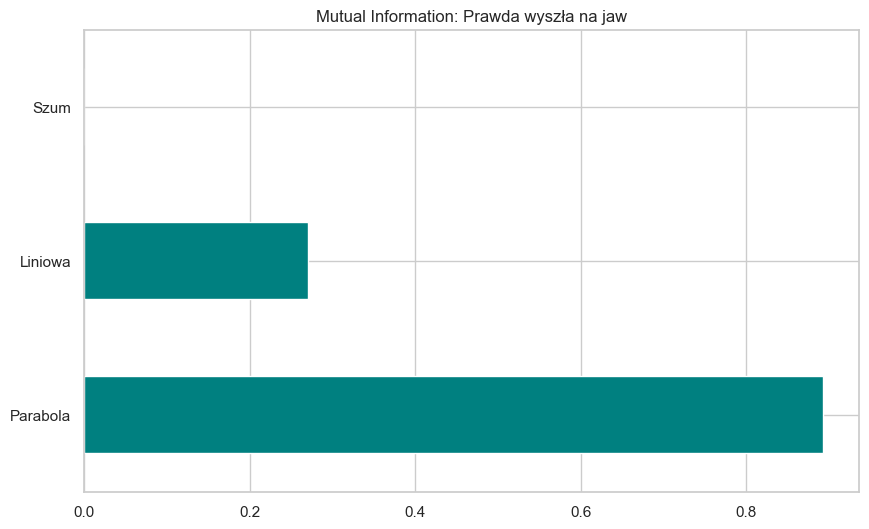

Wniosek: MI poprawnie wykryło, że Parabola jest najważniejsza (nawet ważniejsza niż Liniowa!).


In [8]:
# Przygotowujemy dane
X = df[['Liniowa', 'Parabola', 'Szum']]
y = df['Target']

# Obliczamy Mutual Information
mi_scores = mutual_info_regression(X, y, random_state=42)
mi_series = pd.Series(mi_scores, index=X.columns).sort_values(ascending=False)

print("--- WYNIKI MUTUAL INFORMATION ---")
print(mi_series)

# Wykres
mi_series.plot(kind='barh', color='teal')
plt.title("Mutual Information: Prawda wyszła na jaw")
plt.show()

print("Wniosek: MI poprawnie wykryło, że Parabola jest najważniejsza (nawet ważniejsza niż Liniowa!).")

## Metoda 2: Permutation Importance (Test przez Mieszanie)

To technika, którą możesz zastosować do **każdego** modelu (Drzewa, Sieci Neuronowe).
Jest genialna w swojej prostocie.

**Algorytm:**
1.  Wytrenuj model i zmierz jego błąd (np. 95% skuteczności).
2.  Weź kolumnę "Parabola" i **wymieszaj jej wartości losowo** (zrób jajecznicę). Resztę zostaw bez zmian.
3.  Każ modelowi przewidywać na tych zepsutych danych.
4.  Sprawdź błąd.
    *   Jeśli błąd **wzrósł drastycznie** -> Znaczy, że ta kolumna była kluczowa.
    *   Jeśli błąd **się nie zmienił** -> Znaczy, że model i tak nie patrzył na tę kolumnę (była śmieciem).

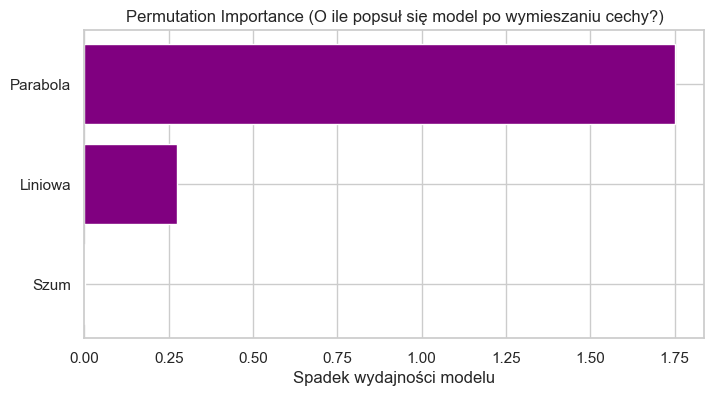

In [9]:
# 1. Musimy mieć wytrenowany model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X, y)

# 2. Uruchamiamy test permutacji (n_repeats=10 oznacza, że mieszamy 10 razy dla pewności)
perm = permutation_importance(model, X, y, n_repeats=10, random_state=42)

# 3. Wizualizacja wyników
cols = X.columns
importances = perm.importances_mean
indices = np.argsort(importances)

plt.figure(figsize=(8, 4))
plt.title("Permutation Importance (O ile popsuł się model po wymieszaniu cechy?)")
plt.barh(range(len(indices)), importances[indices], color='purple', align='center')
plt.yticks(range(len(indices)), [cols[i] for i in indices])
plt.xlabel("Spadek wydajności modelu")
plt.show()

## Metoda 3: SHAP (Wyjaśnialność AI)

Na koniec **SHAP**. To obecnie standard w bankach i medycynie.
Permutation Importance mówi nam, że cecha jest ważna "ogólnie".
SHAP mówi nam, jak cecha wpłynęła na **konkretny przypadek**.

Wykres **Beeswarm (Rój pszczół)** pokazuje wszystko naraz:
*   Każda kropka to jeden wiersz danych.
*   **Kolor:** Czerwony = Wysoka wartość cechy, Niebieski = Niska.
*   **Położenie (lewo/prawo):** Czy ta cecha zwiększyła (prawo) czy zmniejszyła (lewo) wynik modelu?

--- WYKRES SHAP (BEESWARM) ---


C:\Users\takze\AppData\Local\Temp\ipykernel_5620\1178737182.py:7: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X)


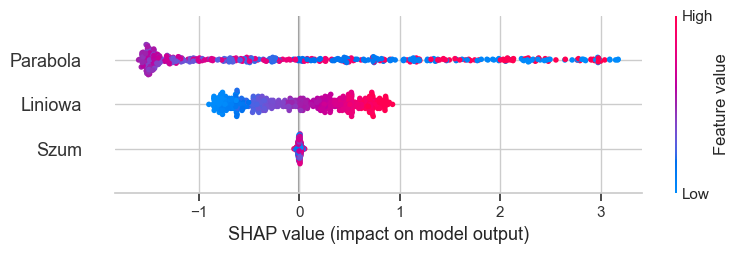

In [10]:
# 1. Tworzymy Explainer (Tłumacza dla modelu drzewiastego)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

# 2. Rysujemy Beeswarm Plot
print("--- WYKRES SHAP (BEESWARM) ---")
shap.summary_plot(shap_values, X)

## 🧠 Jak czytać ten wykres SHAP?

1.  **Liniowa:**
    *   Widzisz, że czerwone kropki (wysokie wartości) są po prawej stronie (zwiększają wynik).
    *   Niebieskie kropki (niskie wartości) są po lewej (zmniejszają wynik).
    *   To logiczne: $y = 2x$. Im więcej, tym więcej.

2.  **Parabola:**
    *   Tutaj kolory są wymieszane!
    *   Zarówno bardzo wysokie (czerwone), jak i bardzo niskie (niebieskie) wartości mogą podbijać wynik (bo $x^2$ zamienia minusy na plusy).
    *   SHAP idealnie pokazuje tę nieliniowość.

3.  **Szum:**
    *   Kropki są skupione na środku (wartość 0 na osi X).
    *   To znaczy, że ta cecha nie popycha modelu ani w górę, ani w dół. Jest ignorowana.

**Wniosek:**
Dzięki SHAP, Mutual Info i Permutation Importance, nie dasz się oszukać fałszywym korelacjom. Twój model będzie widział to, czego "zwykła statystyka" nie widzi.